# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.preprocessing import MinMaxScaler


In [107]:
df = pd.read_csv("eshop.csv")

In [108]:
df.head()
# df.info()


Customer ID       Date  Subtotal         Country
0           34  6/21/2007      86.0  Czech Republic
1           38  6/27/2007      38.4  Czech Republic
2           47   7/2/2007      53.5        Slovakia
3           61  7/14/2007       7.0  Czech Republic
4           78  7/21/2007      55.5  Czech Republic

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


In [155]:
# vytvor rfm

recency = df[['Customer ID','Date']].groupby(by=['Customer ID']).max().rename(columns={'Date':'Recency'})
recency['Recency'] = (pd.to_datetime('12-19-2015') - pd.to_datetime(recency['Recency'])).dt.days
# display(recency)

frequency = df[['Customer ID','Date']].groupby(by=['Customer ID']).count().rename(columns={'Date':'Frequency'})
# display(frequency)

monetary = df[['Customer ID','Subtotal']].groupby(by=['Customer ID']).sum().rename(columns={'Subtotal':'Monetary'})
# display(monetary)

rfm = recency.join([frequency,monetary])
display(rfm)


X = rfm.to_numpy()
print(X.shape)

Recency  Frequency  Monetary
Customer ID                              
7               1011          3     15.54
9               3050          1     13.20
30              3025          1     36.20
34              3103          1     86.00
38              3097          1     38.40
...              ...        ...       ...
15356              1          1     31.87
15357              1          1      6.10
15358              1          1    153.23
15359              0          1     19.15
15360              0          1    139.10

[12829 rows x 3 columns]

(12829, 3)


Vytvoříme slukovaná data pomocí algoritmu k-Means

1. optimalizaci a volbu k nejprve jednoduše odhadneme na základě vykresleného grafu -> najdeme loket

2. optimalizaci provedeme pomocí metody silhouette analysis

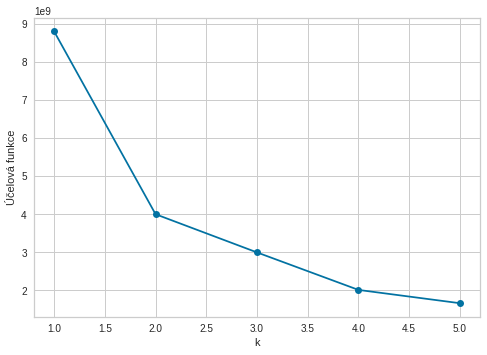

In [156]:
# 1. k-means, odhad k

from sklearn.cluster import KMeans

ix = np.zeros(5)
iy = np.zeros(5)
for k in range(5):
    kmeans = KMeans(n_clusters=k+1, random_state = 1, n_init=2).fit(X)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('k')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

[1 0 0 ... 1 1 1]
[[1.82101310e+03 1.60705290e+00 1.20449347e+02]
 [5.96768985e+02 1.86761711e+00 1.86436971e+02]]


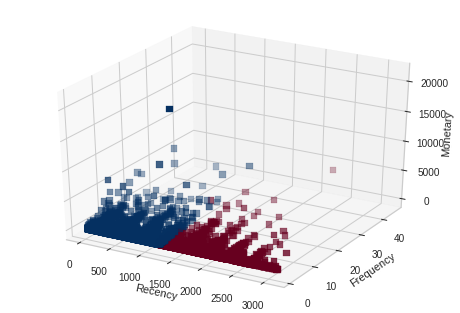

In [193]:
#   podle odhadu volím k=2
k = 2
kmeans = KMeans(n_clusters = k, random_state = 1, n_init = 2).fit(X)

#   výsledné shluky
print(kmeans.labels_)
#   a jejich středy
print(kmeans.cluster_centers_)

#   vizualizace

def visualisation_3d_data(data,labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.array(data[:,0])
    y = np.array(data[:,1])
    z = np.array(data[:,2])

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.scatter(x,y,z, marker="s", c=labels, s=40, cmap="RdBu")

    plt.show()

visualisation_3d_data(X,kmeans.labels_)

"silhouette analýza", její základní proces je převzat z https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. Vizualizaci jsem pak vytvořila pomocí knihovny Yellowbrick z https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

score for  2 is:  0.5464324796084292
score for  3 is:  0.4869969593047542
score for  4 is:  0.5001362145371232
score for  5 is:  0.5137039310469299
score for  6 is:  0.47680492302062727
{'n_clusters': 2}
score:  0.5464324796084292


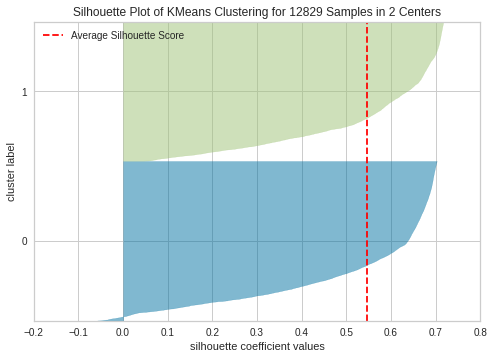

In [163]:
# silhouette analysis
def silhouette(data):
    param_grid = {
        "n_clusters": [2, 3, 4, 5, 6]
    }

    param_comb = ParameterGrid(param_grid)
    val_acc = 0
    for params in param_comb:
        clusterer = KMeans(**params, random_state=10)
        cluster_labels = clusterer.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        print("score for",params["n_clusters"],"clusters is: ",score)
        if val_acc < score:
            opt_params_kmeans = params
            val_acc = score
    print(opt_params_kmeans)
    return opt_params_kmeans

def visualisation_silhouette(model,data):
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(data)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

opt_params_kmeans = silhouette(X)
kmeans = KMeans(**opt_params_kmeans, random_state=10)

cluster_labels = kmeans.fit_predict(X)
score = silhouette_score(X, cluster_labels)
print("score: ",score)
visualisation_silhouette(kmeans,X)


z první visualizace clustru je videt, ze rozsah dat v jednotlivych priznacich neni v podobnych intervalech, proto data znormalizuji do intervalu <0,1> a aplikujeme silhouette analyzu znova

In [159]:
#   data normalization / scalling
def normalization(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

scaled_X = normalization(X.copy())
display(scaled_X)

array([[3.25813729e-01, 4.54545455e-02, 6.71304088e-04],
       [9.82919755e-01, 0.00000000e+00, 5.61913310e-04],
       [9.74863036e-01, 0.00000000e+00, 1.63712181e-03],
       ...,
       [3.22268772e-04, 0.00000000e+00, 7.10806313e-03],
       [0.00000000e+00, 0.00000000e+00, 8.40065073e-04],
       [0.00000000e+00, 0.00000000e+00, 6.44751113e-03]])

score for  2 is:  0.5777242832939866
score for  3 is:  0.5316069648237173
score for  4 is:  0.49736858630452163
score for  5 is:  0.488285195976551
score for  6 is:  0.500273822936264
{'n_clusters': 2}


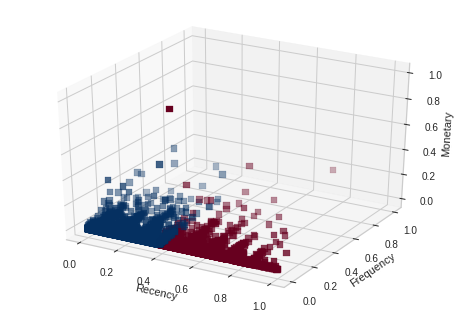

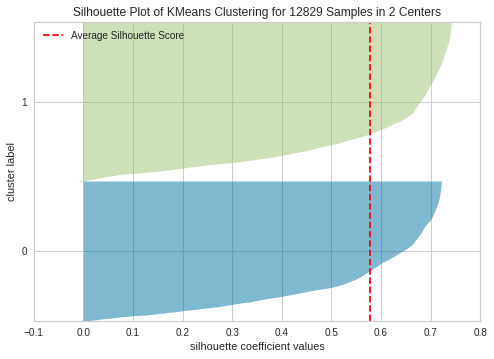

In [164]:
opt_params_kmeans = silhouette(scaled_X)
kmeans = KMeans(**opt_params_kmeans, random_state=10).fit(scaled_X)
visualisation_3d_data(scaled_X,kmeans.labels_)
visualisation_silhouette(kmeans,scaled_X)

k poslednímu ukolu jsem se rozhodla odstranit navstevniky, ktery eshop navstivily pouze jednou

In [189]:
no_one_rfm = rfm[rfm["Frequency"] > 1 ]
Xn = no_one_rfm.to_numpy()
print(Xn.shape)

(3646, 3)


Hledame zakazniky s nizkou recency, vysokou frequency a vysokou monetary...zde tomu nejlepe zrejme vyhovuje cluster s modrymu ctverecky

score for  2 is:  0.4803782526839895
score for  3 is:  0.508517025866415
score for  4 is:  0.5253049003507871
score for  5 is:  0.4456497686982209
score for  6 is:  0.45333088159756085
{'n_clusters': 4}


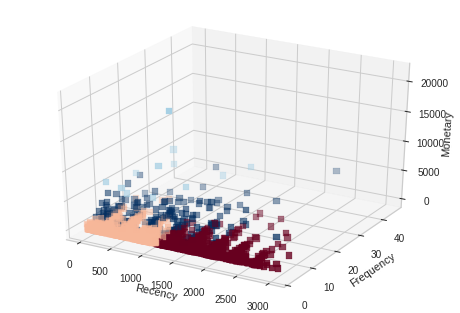

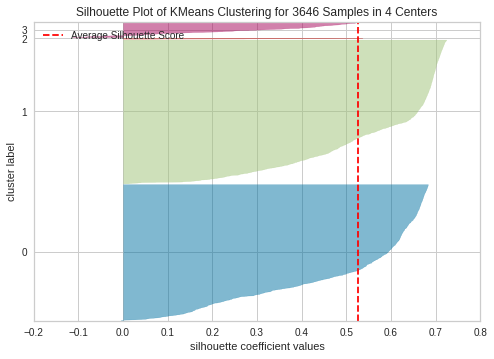

(4, 3)
[0 1 2 3]


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3]

In [206]:

opt_params_kmeans = silhouette(Xn)
kmeans = KMeans(**opt_params_kmeans, random_state=10).fit(Xn)
visualisation_3d_data(Xn,kmeans.labels_)
visualisation_silhouette(kmeans,Xn)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids.shape)
print(np.unique(labels))

superstar = pd.DataFrame([labels]).T.rename(columns={0:"cluster_number"})
display(superstar.groupby(by=['cluster_number']).count()) 